In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 18.7 MB/s eta 0:00:00


In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import math
import mne
%matplotlib inline

In [ ]:
epochs = mne.read_epochs('/content/drive/MyDrive/BCI/BCICompetition/data/Train_set/oddball_train_epo.fif')
#Ruta felipe: /content/drive/MyDrive/P300_PYTHON/drive-download-20230826T021221Z-001.zip (Unzipped Files)/oddball_train_epo.fif
epochs.info

Reading /content/drive/MyDrive/BCI/BCICompetition/data/Train_set/oddball_train_epo.fif ...
    Found the data of interest:
        t =    -300.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
3420 matching events found
No baseline correction applied
0 projection items activated


<Info | 10 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 15.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 64
 projs: []
 sfreq: 240.0 Hz
>

In [ ]:
target = epochs["P300"].pick_channels(['Cz'])#.average()
#target.get_data()

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


In [ ]:
standard = epochs["NoP300"].pick_channels(['Cz'])#.average()
standard

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


Number of events,2850
Events,NoP300: 2850
Time range,-0.300 – 0.700 s
Baseline,-0.300 – 0.000 s


In [ ]:
def ventanas(epochs,m1,m2,m3,m4,F):
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  mean_part1 = np.mean(data_part1[:, :], axis=2)
  mean_part2 = np.mean(data_part2[:, :], axis=2)
  mean_part3 = np.mean(data_part3[:, :], axis=2)
  mean_part4 = np.mean(data_part4[:, :], axis=2)
  return mean_part1, mean_part2, mean_part3, mean_part4

In [54]:
def ventanas_CV(epochs,m1,m2,m3,m4,F):
  prom = np.mean(epochs.get_data())  #, axis=2
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  mean_part1 = np.std(data_part1[:, :], axis=2)/prom
  mean_part2 = np.std(data_part2[:, :], axis=2)/prom
  mean_part3 = np.std(data_part3[:, :], axis=2)/prom
  mean_part4 = np.std(data_part4[:, :], axis=2)/prom
  return mean_part1, mean_part2, mean_part3, mean_part4

In [55]:
mean_target_part1, mean_target_part2 ,mean_target_part3 ,mean_target_part4 = ventanas_CV(target,-0.3,0,0.25,0.4,0.7)
mean_target_part1.shape, mean_target_part2.shape ,mean_target_part3.shape ,mean_target_part4.shape

((570, 64), (570, 64), (570, 64), (570, 64))

In [56]:
mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4 = ventanas_CV(standard,-0.3,0,0.25,0.4,0.7)
mean_standard_part1.shape, mean_standard_part2.shape, mean_standard_part3.shape, mean_standard_part4.shape

((2850, 64), (2850, 64), (2850, 64), (2850, 64))

In [57]:
featuresT = np.concatenate((mean_target_part1, mean_target_part2, mean_target_part3, mean_target_part4), axis=1)
featuresF = np.concatenate((mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4), axis=1)
print(featuresT.shape)
print(featuresF.shape)

(570, 256)
(2850, 256)


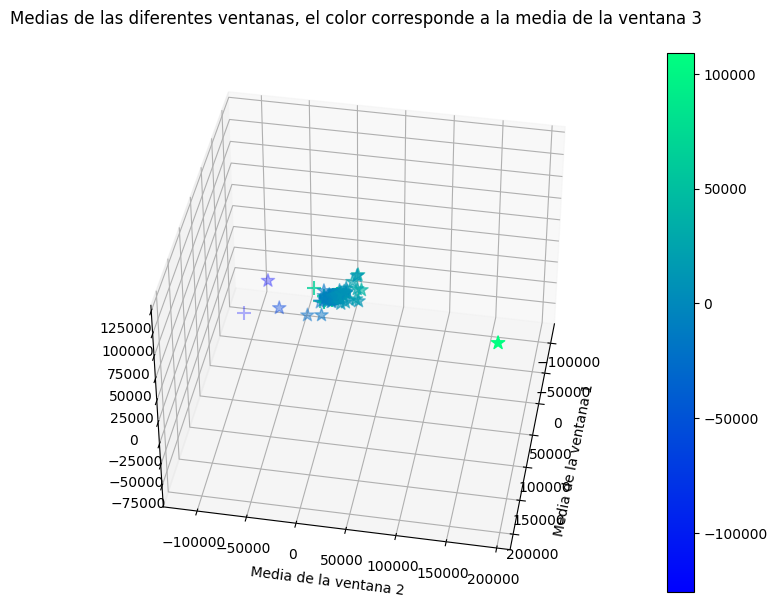

In [58]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = mean_target_part1
y = mean_target_part2
z = mean_target_part4
c = mean_target_part3

x1 = mean_standard_part1
y1 = mean_standard_part2
z1 = mean_standard_part4
c1 = mean_standard_part3

img2 = ax.scatter(x1, y1, z1, c=c1, s = 100, marker = "*", cmap=plt.winter())
fig.colorbar(img2)

plt.xlabel('Media de la ventana 1')
plt.ylabel('Media de la ventana 2')
plt.clabel('Media de la ventana 3')
plt.title("Medias de las diferentes ventanas, el color corresponde a la media de la ventana 3 \n")


img = ax.scatter(x, y, z, c=c, s = 100,marker = "+", cmap=plt.winter())
ax.view_init(40, 10)
#fig.colorbar(img,img2)
fig.savefig('scatter_features_Competition.png')
plt.show()

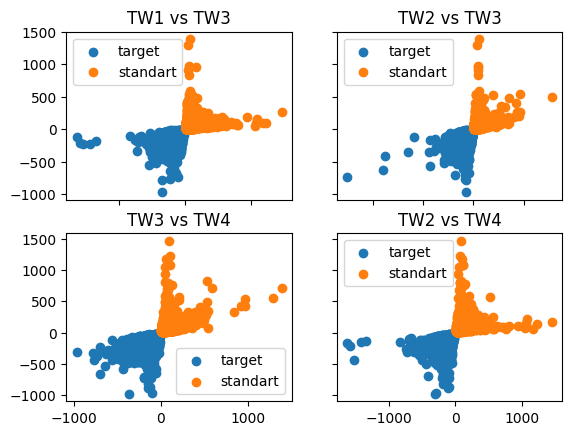

In [52]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].scatter(mean_target_part1,mean_target_part3, label = 'target')
axs[0, 0].scatter(mean_standard_part1,mean_standard_part3, label = 'standart')
axs[0, 0].set_title('TW1 vs TW3')
axs[0, 0].legend()
axs[0, 1].scatter(mean_target_part2,mean_target_part3, label = 'target')
axs[0, 1].scatter(mean_standard_part2,mean_standard_part3, label = 'standart')
axs[0, 1].set_title('TW2 vs TW3')
axs[0, 1].legend()
axs[1, 0].scatter(mean_target_part3, mean_target_part4, label = 'target')
axs[1, 0].scatter(mean_standard_part3, mean_standard_part4, label = 'standart')
axs[1, 0].set_title('TW3 vs TW4')
axs[1, 0].legend()
axs[1, 1].scatter(mean_target_part1,mean_target_part4, label = 'target')
axs[1, 1].scatter(mean_standard_part1,mean_standard_part4, label = 'standart')
axs[1, 1].set_title('TW2 vs TW4')
axs[1, 1].legend()


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

570


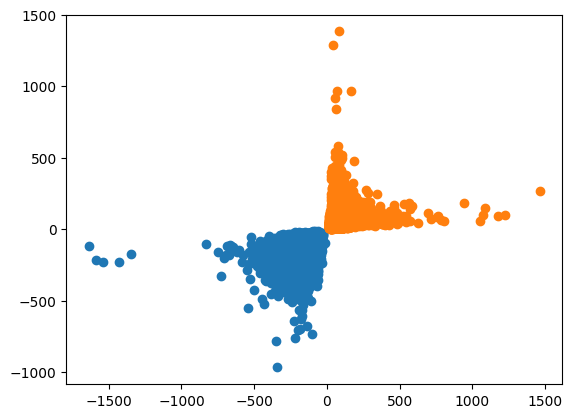

In [53]:
print(len(mean_target_part1))
plt.scatter(mean_target_part1,mean_target_part3)
plt.scatter(mean_standard_part1,mean_standard_part3)

In [ ]:
labelT = np.ones([len(mean_target_part1)])
labelF = np.zeros([len(mean_standard_part1)])
print(labelT.shape)
print(labelF.shape)

(570,)
(2850,)


In [ ]:
features = np.concatenate((featuresT,featuresF), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)

print(features.shape)
print(labels.shape)

(3420, 4)
(3420,)


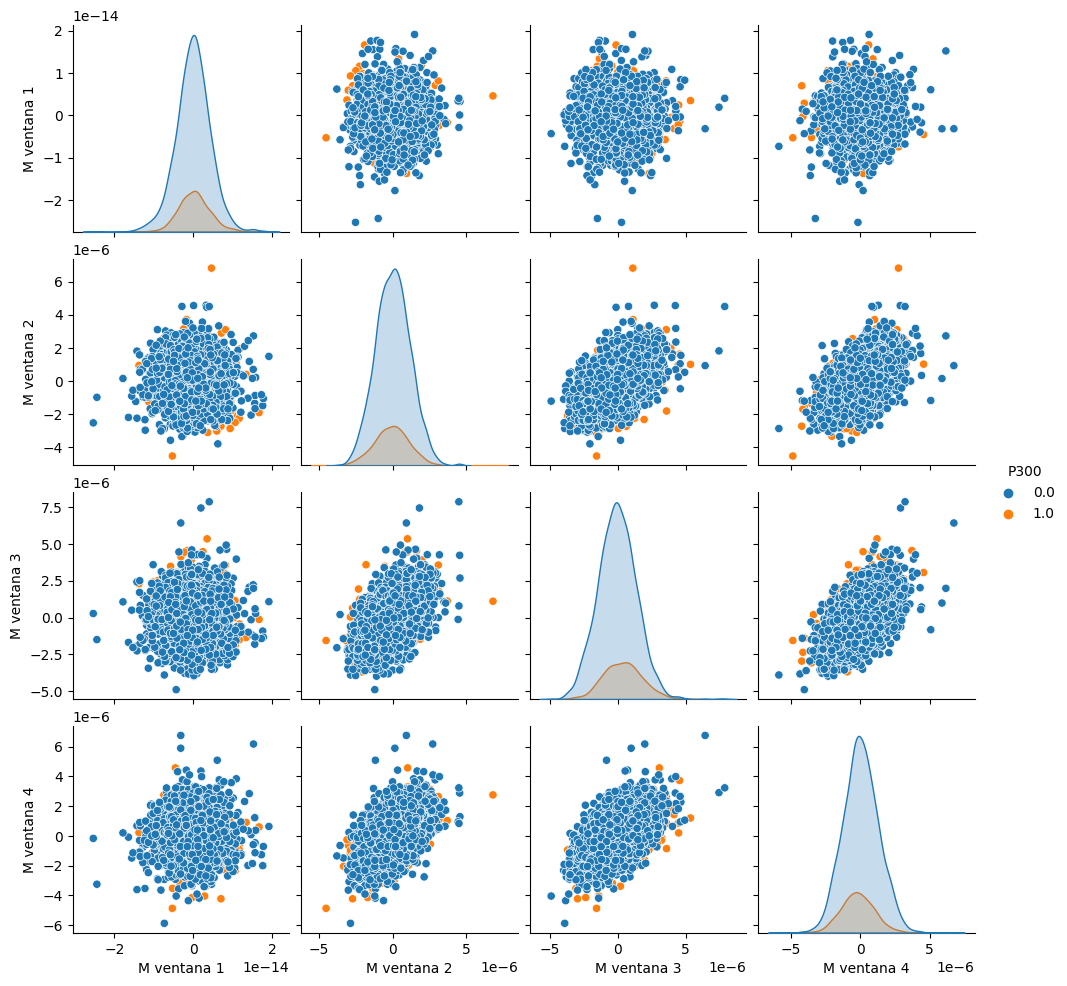

In [ ]:
data_df = pd.DataFrame(features)
data_df.columns = ["M ventana 1", "M ventana 2", "M ventana 3","M ventana 4"]
data_df['P300'] =labels
sns.pairplot(data_df, hue="P300")

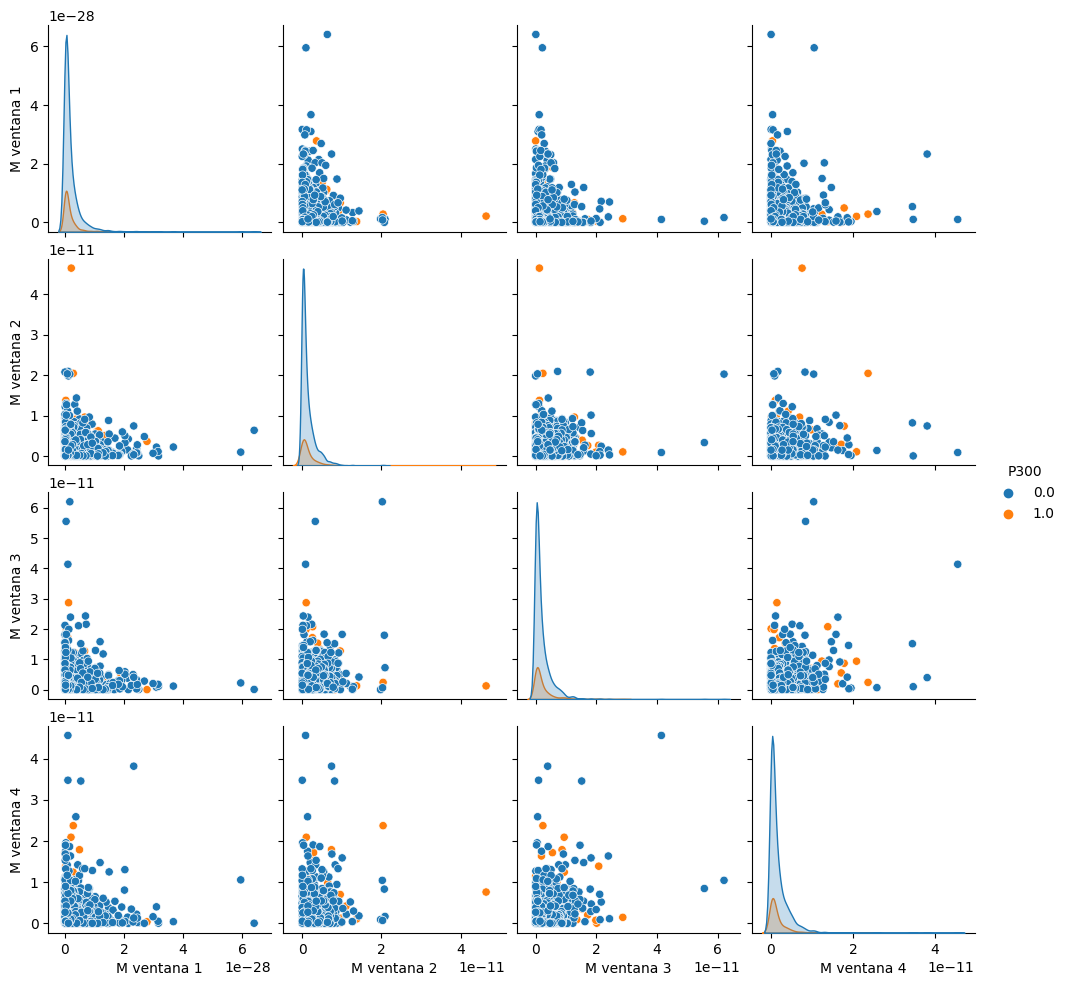

In [ ]:
data_df2 = data_df
data_df2 = data_df2*data_df2
sns.pairplot(data_df2, hue="P300")

In [ ]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate


In [ ]:

# Crear los datos de las características (X) y las etiquetas de las clases (y)
# Estos son datos de prueba, debes reemplazarlos por tus datos reales
X = features # Arreglo con los valores de las cuatro características
y = labels # Arreglo con las etiquetas de las clases (0 o 1)

# Dividir los datos en train y test usando una proporción de 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir el subconjunto de train en train y validation usando una proporción de 75/25
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Mostrar el resultado
print(X_train.shape) # (2052, 4)
print(X_val.shape) # (684, 4)
print(X_test.shape) # (684, 4)

(2052, 4)
(684, 4)
(684, 4)


In [ ]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, make_scorer

# Estos son datos de prueba, debes reemplazarlos por tus datos reales
X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crear el clasificador de discriminante lineal
lda = LinearDiscriminantAnalysis()

# Crear un diccionario que mapee los nombres de las métricas con las funciones
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores1 = cross_validate(lda, X, y, cv=20, scoring=scoring)


print('F1 SCORE:', scores1['test_f1'].mean())
print('Recall:', scores1['test_recall'].mean())
print('Precision:', scores1['test_precision'].mean())
print('Accuracy:', scores1['test_accuracy'].mean())

F1 SCORE: 0.011764705882352941
Recall: 0.00625
Precision: 0.1
Accuracy: 0.8460118027793643


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

In [ ]:
print(scores1)

{'fit_time': array([0.02900076, 0.00272155, 0.00282764, 0.00280213, 0.00268173,
       0.0026722 , 0.00263786, 0.00263739, 0.00278783, 0.00262785,
       0.00302505, 0.00252748, 0.00257874, 0.00253224, 0.00278449,
       0.00297117, 0.00305367, 0.00271797, 0.00254226, 0.00251126]), 'score_time': array([0.00760126, 0.00630665, 0.00716186, 0.0052681 , 0.00585294,
       0.00505137, 0.00581622, 0.00593233, 0.0054605 , 0.00550818,
       0.00525522, 0.00516009, 0.00503731, 0.0053556 , 0.00556469,
       0.00661731, 0.00602293, 0.00502276, 0.00455475, 0.00570965]), 'test_f1': array([0.        , 0.        , 0.        , 0.11764706, 0.        ,
       0.11764706, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'test_recall': array([0.    , 0.    , 0.    , 0.0625, 0.    , 0.0625, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crea una instancia del clasificador Random Forest
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)

# Realiza validación cruzada en los datos
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores2 = cross_validate(rfc, X, y, cv=20, scoring=scoring)

print('F1 SCORE:', scores2['test_f1'].mean())
print('Recall:', scores2['test_recall'].mean())
print('Precision:', scores2['test_precision'].mean())
print('Accuracy:', scores2['test_accuracy'].mean())
print(scores2)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

F1 SCORE: 0.0058823529411764705
Recall: 0.003125
Precision: 0.05
Accuracy: 0.846011802779364
{'fit_time': array([0.20712638, 0.21877289, 0.21411824, 0.21487427, 0.20596457,
       0.21424961, 0.20266199, 0.21013999, 0.21772361, 0.22299075,
       0.21121645, 0.2140336 , 0.20810866, 0.219594  , 0.21137452,
       0.20847917, 0.20479155, 0.22415447, 0.20057964, 0.20467162]), 'score_time': array([0.01215076, 0.01156855, 0.0109098 , 0.01685858, 0.01107621,
       0.01374102, 0.01264024, 0.01165724, 0.01117206, 0.01155496,
       0.01226187, 0.01138163, 0.01192045, 0.01110458, 0.01221251,
       0.01134443, 0.01165581, 0.01104474, 0.0192337 , 0.01419902]), 'test_f1': array([0.        , 0.        , 0.        , 0.11764706, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ]), 'test_recall': array([0.    , 0.    , 0.    , 0.0625, 0.   

In [ ]:
from sklearn.svm import SVC

X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crea una instancia de la clase SVC
svm = SVC(gamma="auto",kernel='rbf', C=1)

# Realiza validación cruzada en los datos
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores3 = cross_validate(svm, X, y, cv=20, scoring=scoring)

print('F1 SCORE:', scores3['test_f1'].mean())
print('Recall:', scores3['test_recall'].mean())
print('Precision:', scores3['test_precision'].mean())
print('Accuracy:', scores3['test_accuracy'].mean())
print(scores3)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

F1 SCORE: 0.0
Recall: 0.0
Precision: 0.0
Accuracy: 0.8465019988577955
{'fit_time': array([0.05345845, 0.0400157 , 0.03873205, 0.03871775, 0.03971148,
       0.04787207, 0.03876209, 0.04088545, 0.03924251, 0.05272794,
       0.03830814, 0.04125857, 0.04568815, 0.03966403, 0.03850412,
       0.03895044, 0.04152203, 0.03861189, 0.04226518, 0.03940535]), 'score_time': array([0.00911045, 0.00873256, 0.00894427, 0.0086658 , 0.00839424,
       0.00930738, 0.01134205, 0.00841546, 0.00929594, 0.01311159,
       0.01029348, 0.00956678, 0.008394  , 0.01316953, 0.00822043,
       0.00848103, 0.00836086, 0.01110005, 0.008564  , 0.00843859]), 'test_f1': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 'test_recall': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 'test_precision': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]), 'test_accuracy': array([0.84466

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score

# Random Forest Classifier

from sklearn import tree

tr = tree.DecisionTreeClassifier(max_depth=7)
tr = tr.fit(X_train, y_train)
y_pred_tr = tr.predict(X_test)
cm_tr = confusion_matrix(y_test, y_pred_tr, normalize='true')
k_tr = cohen_kappa_score(y1=y_test, y2=y_pred_tr)
pre_tr = precision_score(y_true=y_test , y_pred= y_pred_tr)
acc_tr = accuracy_score(y_true=y_test , y_pred= y_pred_tr)
rec_tr = recall_score(y_true=y_test , y_pred= y_pred_tr)
f1_tr = f1_score(y_true=y_test , y_pred= y_pred_tr)
#roc_auc_rfc = roc_auc_score(y_true=y_test , y_pred= y_pred_rfc)
print('Tree Classifier:\n',cm_tr)
print('precision: ', pre_tr)
print('accuracy:  ',acc_tr)
print('recall:    ',rec_tr)
print('f1_score:  ',f1_tr)
print('Kappa:     ', k_tr, '\n')

# Random Forest Classifier
rfc.fit(X, y)
y_pred_rfc = rfc.predict(X_test)
cm_rfc = confusion_matrix(y_test, y_pred_rfc, normalize='true')
k_rfc = cohen_kappa_score(y1=y_test, y2=y_pred_rfc)
pre_rfc = precision_score(y_true=y_test , y_pred= y_pred_rfc)
acc_rfc = accuracy_score(y_true=y_test , y_pred= y_pred_rfc)
rec_rfc = recall_score(y_true=y_test , y_pred= y_pred_rfc)
f1_rfc = f1_score(y_true=y_test , y_pred= y_pred_rfc)
#roc_auc_rfc = roc_auc_score(y_true=y_test , y_pred= y_pred_rfc)
print('Random Forest Classifier:\n',cm_rfc)
print('precision: ', pre_rfc)
print('accuracy:  ',acc_rfc)
print('recall:    ',rec_rfc)
print('f1_score:  ',f1_rfc)
print('Kappa:     ', k_rfc, '\n')
#print('roc_auc',roc_auc_rfc)


# Linear Discriminant Analysis
lda.fit(X, y)
y_pred_lda = lda.predict(X_test)
cm_lda = confusion_matrix(y_test, y_pred_lda, normalize='true')
k_lda = cohen_kappa_score(y1=y_test, y2=y_pred_lda)
pre_lda = precision_score(y_true=y_test , y_pred= y_pred_lda)
acc_lda = accuracy_score(y_true=y_test , y_pred= y_pred_lda)
rec_lda = recall_score(y_true=y_test , y_pred= y_pred_lda)
f1_lda = f1_score(y_true=y_test , y_pred= y_pred_lda)
#roc_auc_rfc = roc_auc_score(y_true=y_test , y_pred= y_pred_rfc)
print('Linear Discriminant Analysis:\n', cm_lda)
print('precision: ', pre_lda)
print('accuracy:  ',acc_lda)
print('recall:    ',rec_lda)
print('f1_score:  ',f1_lda)
print('Kappa:     ', k_lda, '\n')


#Support Vector Machine Classifier
svm.fit(X, y)
y_pred_svm = lda.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm, normalize='true')
print('Support Vector Machine:\n', cm_svm)
k_svm = cohen_kappa_score(y1=y_test, y2=y_pred_svm)
pre_svm = precision_score(y_true=y_test , y_pred= y_pred_svm)
acc_svm = accuracy_score(y_true=y_test , y_pred= y_pred_svm)
rec_svm = recall_score(y_true=y_test , y_pred= y_pred_svm)
f1_svm = f1_score(y_true=y_test , y_pred= y_pred_svm)
#roc_auc_rfc = roc_auc_score(y_true=y_test , y_pred= y_pred_rfc)
print('Linear Discriminant Analysis:\n', cm_svm)
print('precision: ', pre_svm)
print('accuracy:  ',acc_svm)
print('recall:    ',rec_svm)
print('f1_score:  ',f1_svm)
print('Kappa:     ', k_svm, '\n')

Tree Classifier:
 [[0.99082569 0.00917431]
 [0.98561151 0.01438849]]
precision:  0.2857142857142857
accuracy:   0.7923976608187134
recall:     0.014388489208633094
f1_score:   0.0273972602739726
Kappa:      0.008067975244592573 

Random Forest Classifier:
 [[1. 0.]
 [1. 0.]]
precision:  0.0
accuracy:   0.7967836257309941
recall:     0.0
f1_score:   0.0
Kappa:      0.0 

Linear Discriminant Analysis:
 [[0.99449541 0.00550459]
 [1.         0.        ]]
precision:  0.0
accuracy:   0.7923976608187134
recall:     0.0
f1_score:   0.0
Kappa:      -0.00866097576172975 

Support Vector Machine:
 [[0.99449541 0.00550459]
 [1.         0.        ]]
Linear Discriminant Analysis:
 [[0.99449541 0.00550459]
 [1.         0.        ]]
precision:  0.0
accuracy:   0.7923976608187134
recall:     0.0
f1_score:   0.0
Kappa:      -0.00866097576172975 



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#from sklearn.metrics import clasification_report
#print(clasification_report(y_test, y_pred_rfc))

https://www.fisterra.com/formacion/metodologia-investigacion/medidas-concordancia-indice-kappa/

[0.         0.34846448 0.29454669 0.35698883]
['M ventana 1', 'M ventana 2', 'M ventana 3', 'M ventana 4']


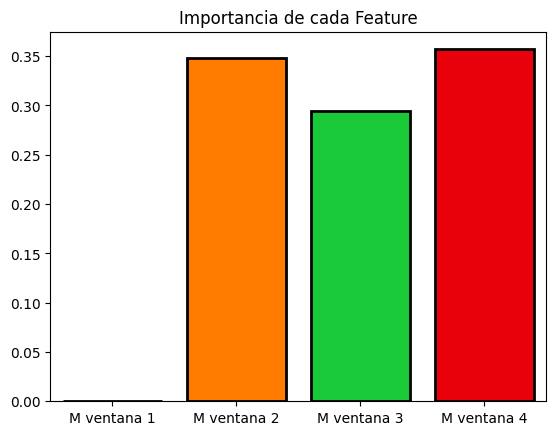

In [ ]:
importances = rfc.feature_importances_
print(importances)
columns = ['M ventana 1', 'M ventana 2', 'M ventana 3', 'M ventana 4']
print(columns)
sns.barplot(x=columns, y=importances, palette='bright', saturation=2.0, edgecolor='black', linewidth=2)
plt.title('Importancia de cada Feature')
plt.show()

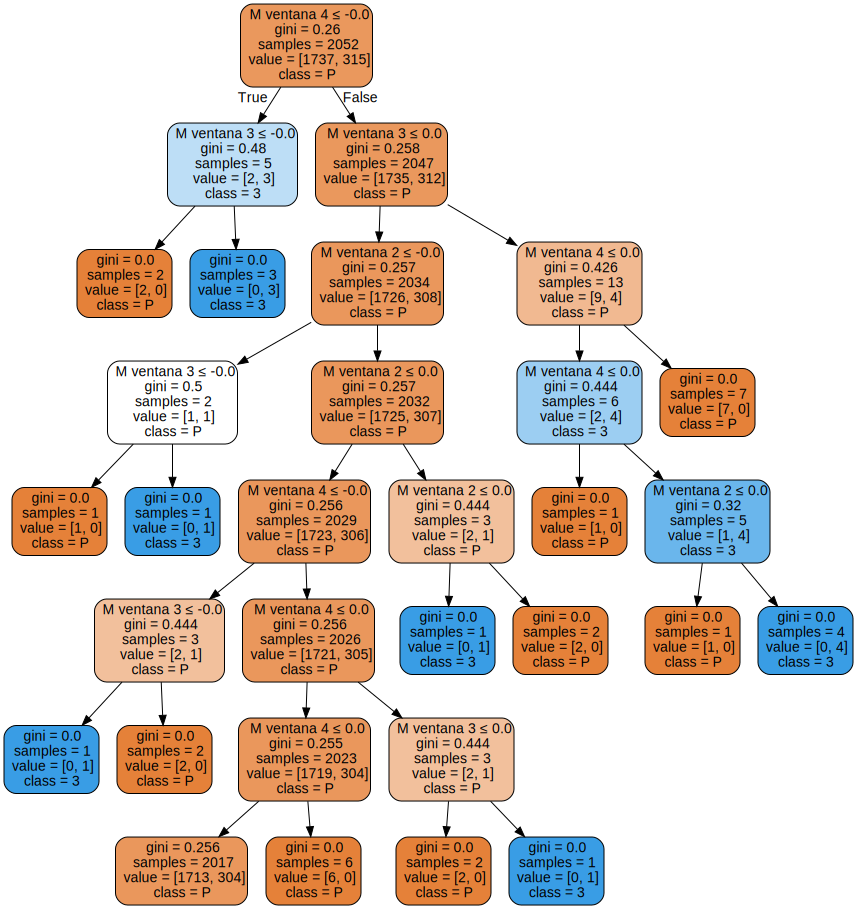

In [ ]:
import graphviz
dot_data = tree.export_graphviz(tr, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("iris")


dot_data = tree.export_graphviz(tr, out_file=None,
                         feature_names=columns,
                         class_names='P300',
                         filled=True, rounded=True,
                         special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
import pandas as pd
data_tuples = list(zip(scores1.keys(), scores1.values()))
df1 = pd.DataFrame(data=data_tuples, columns=['metric', 'values'])
df1 = df1.explode('values')
df1['classifier'] = 'LDA'
df1

,metric,values,classifier
0,fit_time,0.029001,LDA
0,fit_time,0.002722,LDA
0,fit_time,0.002828,LDA
0,fit_time,0.002802,LDA
0,fit_time,0.002682,LDA
...,...,...,...
5,test_accuracy,0.852941,LDA
5,test_accuracy,0.852941,LDA
5,test_accuracy,0.843137,LDA
5,test_accuracy,0.833333,LDA


In [ ]:
data_tuples2 = list(zip(scores2.keys(), scores2.values()))
df2 = pd.DataFrame(data=data_tuples2, columns=['metric', 'values'])
df2 = df2.explode('values')
df2['classifier'] = 'Random Forest'
df2

,metric,values,classifier
0,fit_time,0.207126,Random Forest
0,fit_time,0.218773,Random Forest
0,fit_time,0.214118,Random Forest
0,fit_time,0.214874,Random Forest
0,fit_time,0.205965,Random Forest
...,...,...,...
5,test_accuracy,0.852941,Random Forest
5,test_accuracy,0.852941,Random Forest
5,test_accuracy,0.843137,Random Forest
5,test_accuracy,0.843137,Random Forest


In [ ]:
data_tuples3 = list(zip(scores3.keys(), scores3.values()))
df3 = pd.DataFrame(data=data_tuples3, columns=['metric', 'values'])
df3 = df3.explode('values')
df3['classifier'] = 'SVM'
df3

,metric,values,classifier
0,fit_time,0.053458,SVM
0,fit_time,0.040016,SVM
0,fit_time,0.038732,SVM
0,fit_time,0.038718,SVM
0,fit_time,0.039711,SVM
...,...,...,...
5,test_accuracy,0.852941,SVM
5,test_accuracy,0.852941,SVM
5,test_accuracy,0.843137,SVM
5,test_accuracy,0.843137,SVM


In [ ]:
df = pd.concat([df1, df2, df3], axis = 0)
df

,metric,values,classifier
0,fit_time,0.029001,LDA
0,fit_time,0.002722,LDA
0,fit_time,0.002828,LDA
0,fit_time,0.002802,LDA
0,fit_time,0.002682,LDA
...,...,...,...
5,test_accuracy,0.852941,SVM
5,test_accuracy,0.852941,SVM
5,test_accuracy,0.843137,SVM
5,test_accuracy,0.843137,SVM


In [ ]:
metrics_to_select = ['test_f1', 'test_recall', 'test_precision', 'test_accuracy']
df_selected = df.loc[df['metric'].isin(metrics_to_select)]
df_selected

,metric,values,classifier
2,test_f1,0.0,LDA
2,test_f1,0.0,LDA
2,test_f1,0.0,LDA
2,test_f1,0.117647,LDA
2,test_f1,0.0,LDA
...,...,...,...
5,test_accuracy,0.852941,SVM
5,test_accuracy,0.852941,SVM
5,test_accuracy,0.843137,SVM
5,test_accuracy,0.843137,SVM


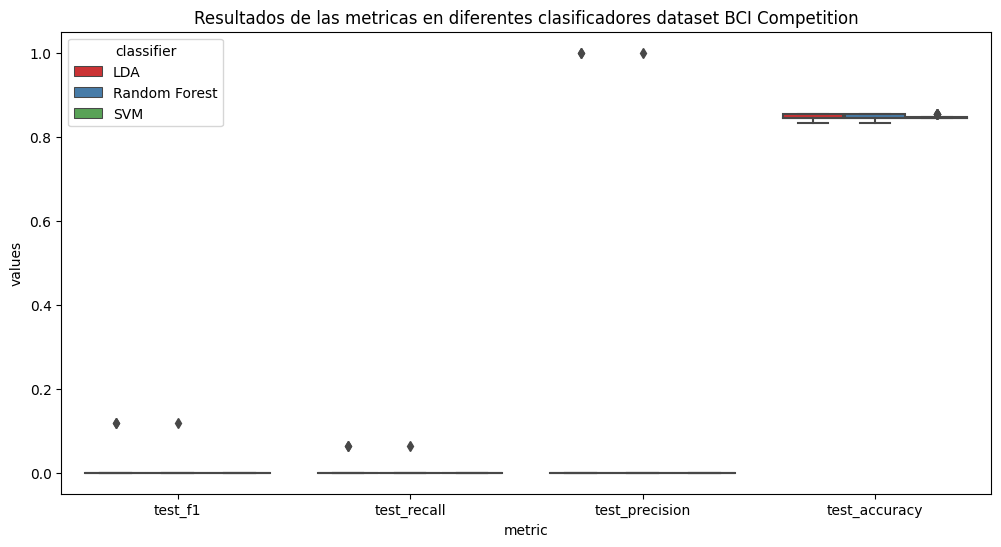

In [59]:
# DATOS DE ENTRADA
variable_numerica = "values"
variable_categorica_agrupacion = "metric"
variable_categorica_agrupacion2 = "classifier"
titulo_grafico = "Resultados de las metricas en diferentes clasificadores dataset BCI Competition"

#Gráfico Boxplot a una sola variable númerica según dos categorica
plt.figure(figsize=(12,6))
sns.boxplot(x=variable_categorica_agrupacion, y=variable_numerica, hue=variable_categorica_agrupacion2, data=df_selected, palette="Set1")
plt.title(titulo_grafico)
plt.savefig('boxplot_Competition')
plt.show()

## Clasificación con redes convolucionales
Se utiliza Keras para realizar la clasificación

In [ ]:
np.squeeze(epochs["P300"][1].get_data()).shape

(64, 241)

In [ ]:
len(epochs["NoP300"])

2850

In [ ]:
target = epochs["P300"]
standard = epochs["NoP300"]
labelT = np.ones([len(epochs["P300"])])
labelF = np.zeros([len(epochs["NoP300"])])
features = np.concatenate((target,standard), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)
labels = labels.reshape(-1,1)
labels.shape, features.shape

((3420, 1), (3420, 64, 241))

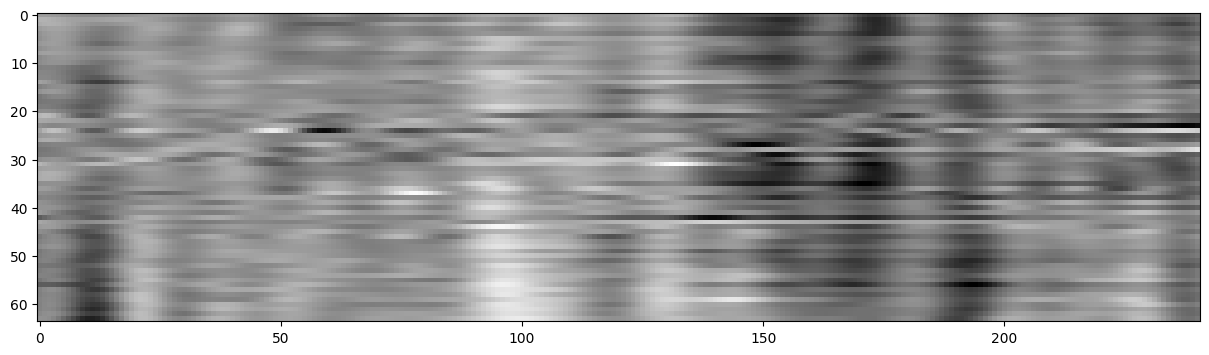

In [ ]:
plt.figure(1, figsize=(15, 7))
plt.imshow(np.squeeze(epochs["P300"][6].get_data()), cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

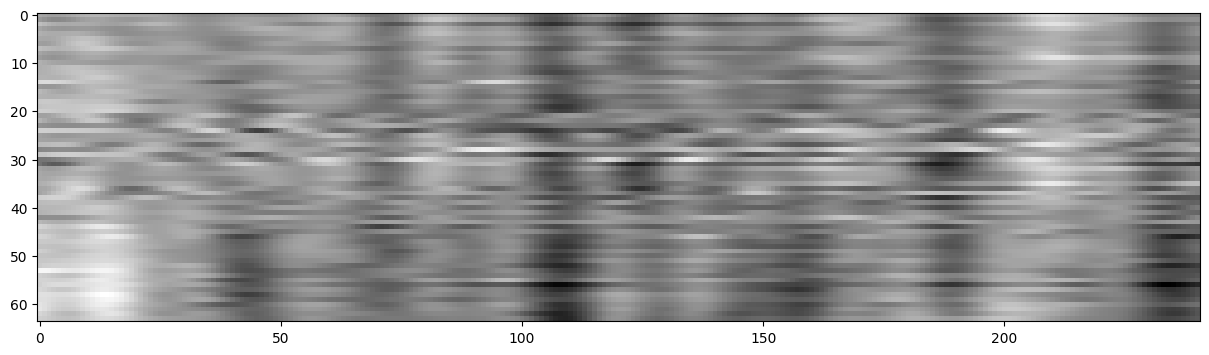

In [ ]:
plt.figure(1, figsize=(15, 7))
plt.imshow(np.squeeze(epochs["NoP300"][6].get_data()), cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
X = features # Arreglo con los valores de las cuatro características
y = labels # Arreglo con las etiquetas de las clases (0 o 1)

# Dividir los datos en train y test usando una proporción de 80/20
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir los datos en train y validation usando una proporción de 80/20
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.metrics import Accuracy, AUC, Precision, Recall

# Crear modelo
model = Sequential()

# Agregar capas
model.add(Conv2D(64, kernel_size=2, activation='relu', input_shape=(64,241,1)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.add(Dense(1, activation='softmax'))

# Compilar modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Accuracy(), AUC(), Precision(), Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 240, 64)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 80, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 79, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 26, 32)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4992)              0         
                                                                 
 dense (Dense)               (None, 3)                 1

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
69/69 [==============================] - 43s 603ms/step - loss: 0.4907 - accuracy: 4.5704e-04 - auc: 0.5000 - precision: 0.1559 - recall: 1.0000 - val_loss: 0.4735 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_precision: 0.1642 - val_recall: 1.0000
Epoch 2/10
69/69 [==============================] - 40s 587ms/step - loss: 0.4593 - accuracy: 0.0000e+00 - auc: 0.5000 - precision: 0.1559 - recall: 1.0000 - val_loss: 0.4643 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_precision: 0.1642 - val_recall: 1.0000
Epoch 3/10
69/69 [==============================] - 39s 569ms/step - loss: 0.4510 - accuracy: 4.5704e-04 - auc: 0.5000 - precision: 0.1559 - recall: 1.0000 - val_loss: 0.4580 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_precision: 0.1642 - val_recall: 1.0000
Epoch 4/10
69/69 [==============================] - 38s 546ms/step - loss: 0.4451 - accuracy: 4.5704e-04 - auc: 0.5000 - precision: 0.1559 - recall: 1.0000 - val_loss: 0.4538 - val_accuracy: 0.0000e+00 - v

[0.49067121744155884, 0.45927557349205017, 0.4510214328765869, 0.4451414942741394, 0.44100210070610046, 0.43818145990371704, 0.4362879693508148, 0.435014009475708, 0.434223473072052, 0.43365129828453064]
[0.0004570384044200182, 0.0, 0.0004570384044200182, 0.0004570384044200182, 0.0, 0.0004570384044200182, 0.0, 0.0004570384044200182, 0.0, 0.0]


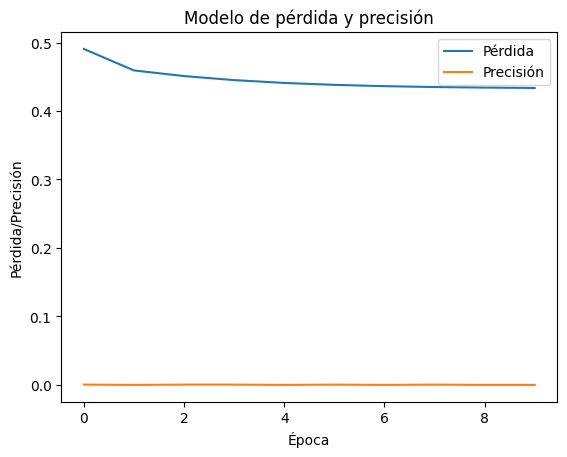

In [ ]:
print(history.history['loss'])
print(history.history['accuracy'])

# Graficar pérdida y precisión
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Modelo de pérdida y precisión')
plt.ylabel('Pérdida/Precisión')
plt.xlabel('Época')
plt.legend(['Pérdida', 'Precisión'], loc='upper right')
plt.show()